In [153]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 200
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Median qi's
### Pool

In [105]:

# These files have the time evolution of Q, q, i quantiles.
# filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'

df_x0var_pool_l = []
T = 16 - 1
for sizes in ['logn90', 'pareto']:
    print(sizes)
    for dist in ['emp_szd_T16','norm', 'lapl']:
        print(dist)
        # Load previously simulated
#         filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
#         df = pd.read_csv(filename).set_index(['Q', 'q', 'i']).sort_index()
        df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_40i_.csv')

#         df['ti'] = df['var_qi']/df['s']**2
#         df['tdiffi'] = df['var_diff_qi']/df['s']**2

        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])

    #     hvar = 'ti'
        hvar = 'var_diff_qi'
        hvar0 = 'var_diff_q0'
        
        
        df = df.reset_index()
        df['dev_median'] = df.groupby(['s', 'Q', 'q'])[hvar].apply(lambda x: abs(x - x.median()))
        df_x0var_pool = df.groupby(['s', 'Q', 'q']).apply(lambda x: x.nsmallest(2, 'dev_median').reset_index(drop = True))

        # When we isolated cases i from their original experiment, they must not carry the aggregate 'y' anymore.
        df_x0var_pool = df_x0var_pool.drop(['var_agg_i', 'var_diff_agg_i'], axis = 1)
        # They will be redefined for any mix of qi time series.
        df_x0var_pool_l += [df_x0var_pool]
        
x0_pool = pd.concat(df_x0var_pool_l).reset_index(drop = True)

logn90
emp_szd_T16
norm
lapl
pareto
emp_szd_T16
norm
lapl


In [ ]:
## Estimate line to be subtracted from time series of diff.
# It is the derivative of the distortion in ts introduced by widening accumulated shocks, which being log lead to an expansion of the total because 1.1 - 1/1.1 > 1.

In [237]:

medianq_size_grs_l = []
T = 16 - 1
for sizes in ['logn90', 'pareto']:
    print(sizes)

    for dist in ['norm', 'lapl']:
        print(dist)
        # Load previously simulated
        df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_40i_.csv')
        
        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])

    #     hvar = 'ti'
        hvar = 'var_diff_qi'
        hvar0 = 'var_diff_q0'
        
#         meanq = np.log10(df.reset_index().groupby(['Q'])[[str(t) for t in range(T + 1)]].mean()).T
#         meanq.diff().plot(ax = ax, c = '.6')
        medianq_size_grs = np.log10(df.reset_index().groupby(['Q'])[[str(t) for t in range(T + 1)]].median()).T.diff()
        medianq_size_grs_l += [medianq_size_grs]

logn90
norm
lapl
pareto
norm
lapl


In [ ]:

fig, ax = plt.subplots(1)
medianq = pd.concat(medianq_size_grs_l)
medianq.index.name = 'T'
medianq.index = medianq.index.astype(int)
data = medianq.reset_index().dropna()
data.plot(x = 'T', ax = ax, c = '.5', marker = '.', lw = 0)
fit_data = data.groupby('T').mean().mean(1)
fit_data.plot(marker = 'o', color = 'r', lw = 0)

line = np.polyfit(fit_data.index, fit_data.values, 1)
plt.plot(range(16), line[0]*range(16) + line[1], color = 'r')

# plt.show()
# This identifies well what is going on, but the main problem is that there is huge dispersion so that it is actually useless to have the curve for medians.


# Get the factors right (the curve needs to recover a constant after having been integrated from the line)

# meanq = np.log10(df.reset_index().groupby(['Q'])[[str(t) for t in range(T + 1)]].mean()).T
# meanq.diff().plot()
medianq = np.log10(df.reset_index().groupby(['Q'])[[str(t) for t in range(T + 1)]].median()).T
medianq.plot()
plt.plot(range(16), 10 + np.cumsum(line[0]*range(16) + line[1]), linestyle = '--')
# plt.ylim(0,)
# plt.yscale('log')

# Check that it's useless

curve_fit = np.cumsum(line[0]*range(16) + line[1])
curve_fit = curve_fit - curve_fit[-1] #let the last element set the reference level
factor = np.power(10, curve_fit)

df[[str(t) for t in range(T + 1)]].div(factor, 1).sample(20).T.plot(legend = False)
df[[str(t) for t in range(T + 1)]].sample(20).T.plot(legend = False)
plt.yscale('log')

## An approach for solving the dependence of sigma on a single sigma_q
In the limit sigma_q rising from zero. All other quantiles fixed to be (Q - 1) * mean(x_q(t))
Their sigma will be zero so we can finally see what is the dependence with a single sq.

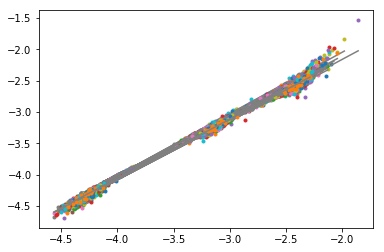

In [447]:

df_x0var_pool_l = []
T = 16 - 1
fig, ax = plt.subplots(1)

fit_results = []
for sizes in ['logn90', 'pareto']:
#     print(sizes)

    for dist in ['emp_szd_T16','norm', 'lapl']:
#         print(dist)
        # Load previously simulated
        df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_40i_.csv')
        
        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])

    #     hvar = 'ti'
        hvar = 'var_diff_qi'
        hvar0 = 'var_diff_q0'
        
        df = df.reset_index()
        df = df.drop(['var_agg_i','var_diff_agg_i'], axis = 1)
        
        for q in [0, 1, 2]:
            df_s_q = df.loc[(df.s < 0.35) & (df.q == q)]

            points = df_s_q.sort_values(by = 'var_diff_qi')

            lin_vals = points[[str(t) for t in range(T + 1)]]

            rest_of_value = (points.Q - 1)*lin_vals.mean(1) # the value in Q-1 fixed quantiles
            value_sum = (lin_vals.T + rest_of_value.values).T

            points['var_diff_agg_i'] = np.log10(value_sum).diff(axis = 1).var(1)
            points['std_diff_agg_i'] = np.log10(value_sum).diff(axis = 1).std(1)

            for Q in np.sort(points.Q.unique()):
    #             print(Q)
                points_Q = points.loc[points.Q == Q]
            #     points_Q['y'] = points_Q['var_diff_agg_i'] #
                x = np.log10(points_Q.var_diff_qi)
                y_var = np.log10(points_Q.var_diff_agg_i * Q**2)
                ax.plot(x, y_var, marker = '.', lw = 0)
            #     y_std = np.log10(points_Q.std_diff_agg_i)
            #     ax.plot(x, y_std, marker = '+', lw = 0)

                line = np.polyfit(x, y_var, 1)
                ax.plot(x, line[0]*x + line[1], c = '.5')

                fit_results += [np.hstack((line, [q, Q, dist, sizes]))]


In [427]:
fit_results_df = pd.DataFrame(fit_results, columns = ['slope', 'ord', 'q', 'Q', 'grs', 'sizes'], dtype = float)

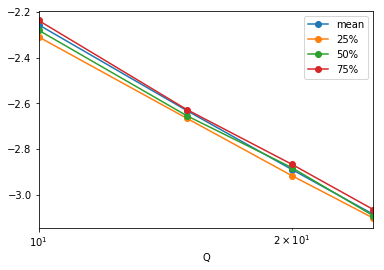

In [446]:
desc_ord_Q = fit_results_df.groupby(['Q'])['ord'].describe()[['mean', '25%', '50%', '75%']]
desc_ord_Q.plot(marker = 'o')
plt.xscale('log')

desc_ord_Q['log_Q'] = np.log10(desc_ord_Q.index.values)


In [445]:
line = np.polyfit(desc_ord_Q.log_Q, desc_ord_Q['50%'], 1)
line

array([-2.01461052, -0.27045689])

,mean,25%,50%,75%,log_Q
Q,,,,,
10.0,-2.256709,-2.309618,-2.280440,-2.237925,1.000000
15.0,-2.630700,-2.664361,-2.653234,-2.626380,1.176091
20.0,-2.887896,-2.914721,-2.879826,-2.865116,1.301030
25.0,-3.083512,-3.099867,-3.089678,-3.062691,1.397940


In [ ]:
### function: compute M cases of agregate volatility from the pool

In [152]:
def compute(x0_pool_part, M = 20):
    var_i_list = []
    var_diff_i_list = []
    for m in range(M):
        sim_m = x0_pool_part.groupby('q').apply(lambda x: x.sample())
        # sim_m['test'] = sim_m['var_diff_qi'] + sim_m['dev_median']

        value_sum = sim_m[[str(t) for t in range(T + 1)]].sum()
        # sim_m plays the role of df_i in the loops I was using before

        var_i = np.log10(value_sum).std() # we possibly want the var of logs.
        var_diff_i = np.log10(value_sum).diff().std() 
        var_i_list += [var_i]
        var_diff_i_list += [var_diff_i]
    print('computed')
    return pd.DataFrame([var_i_list, var_diff_i_list], index = ['agg_var', 'agg_diff_var'])


In [527]:
print(len(x0_pool[['sizes', 'dist', 's', 'Q']].drop_duplicates()))
median_y = x0_pool.groupby(['sizes', 'dist', 's', 'Q']).apply(lambda x: compute(x))

120
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
computed
comput

In [528]:
describe = median_y.T.describe().T
# s = describe
# s.loc[s.index.get_level_values(4) == 'var_diff_i_list'].style.bar(color='#d65f5f')

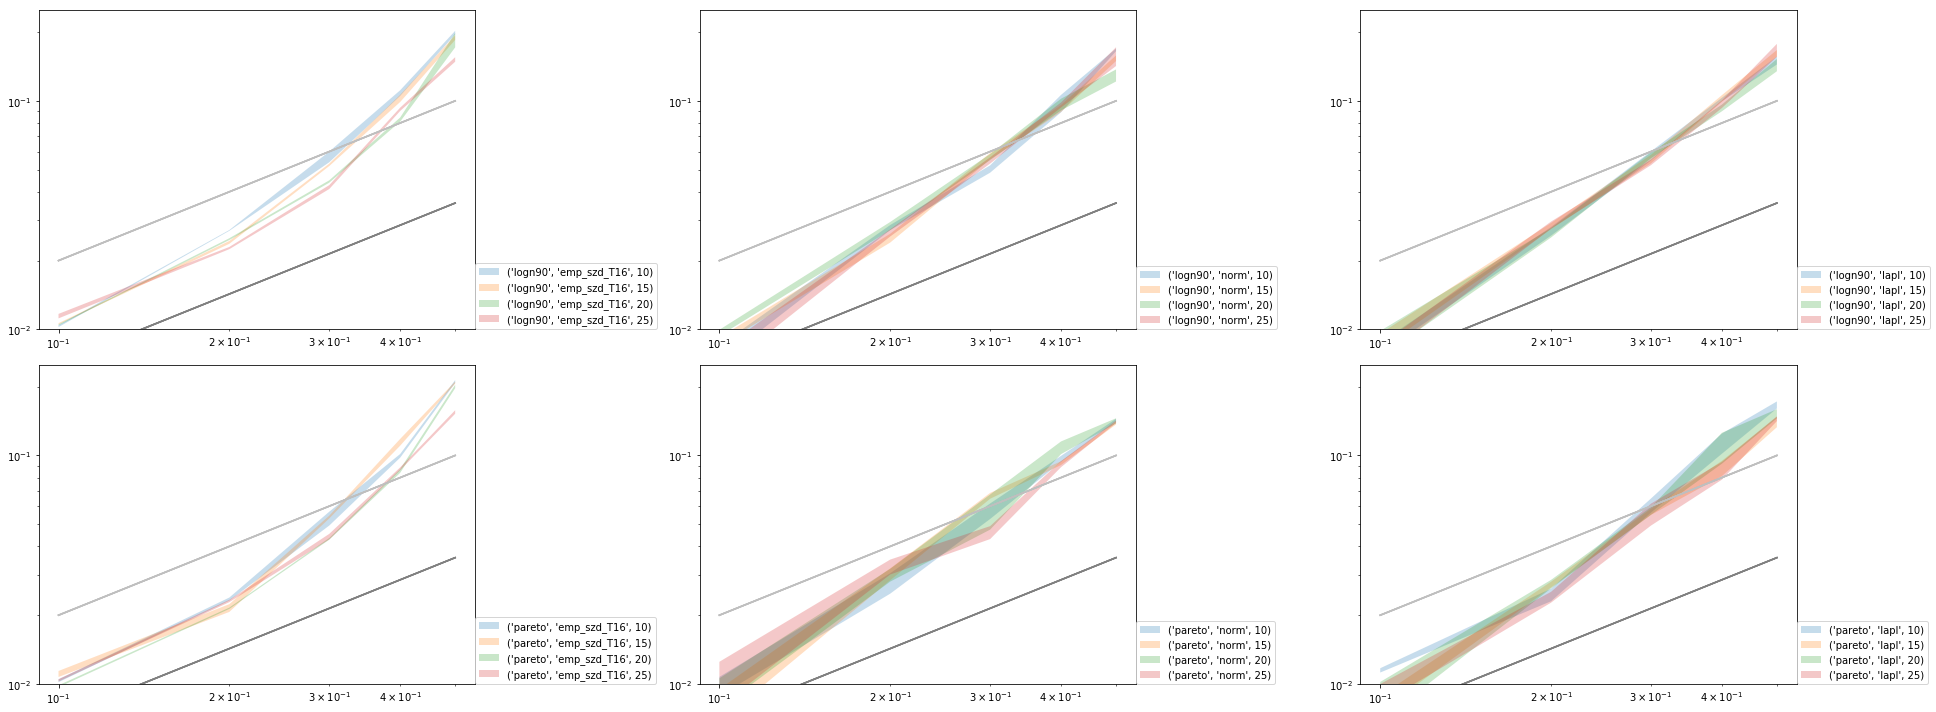

In [529]:
# There should not be a dependence with Q.
# Let's see the dependence with s.

fig, axs = plt.subplots(2, 3, figsize = (27, 10))

for j, sizes in enumerate(['logn90', 'pareto']):
    for k, dist in enumerate(['emp_szd_T16','norm', 'lapl']):
        ax = axs[j][k]
        data = describe.loc[sizes].loc[dist]
        data = data.reset_index()
        for Q in [10, 15, 20, 25]:
            dataQ = data.loc[data.Q == Q]
            dataQ = dataQ.set_index(['s', 'level_2'])[['25%','50%','75%']].unstack()
            dataQ.columns = dataQ.columns.swaplevel()

            data_plot = dataQ['agg_diff_var']

            ax.fill_between(data_plot.index, data_plot['25%'], data_plot['75%'], alpha = .25, label = str((sizes, dist, Q)))
            ax.plot(data_plot.index, (data_plot.index)/14, c=  '.5', label = '_')
            ax.plot(data_plot.index, (data_plot.index)/5, c=  '.75', label = '_')
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.legend(loc = (1,0))
            ax.set_ylim(1e-2, .25)
plt.tight_layout()
plt.show()
                

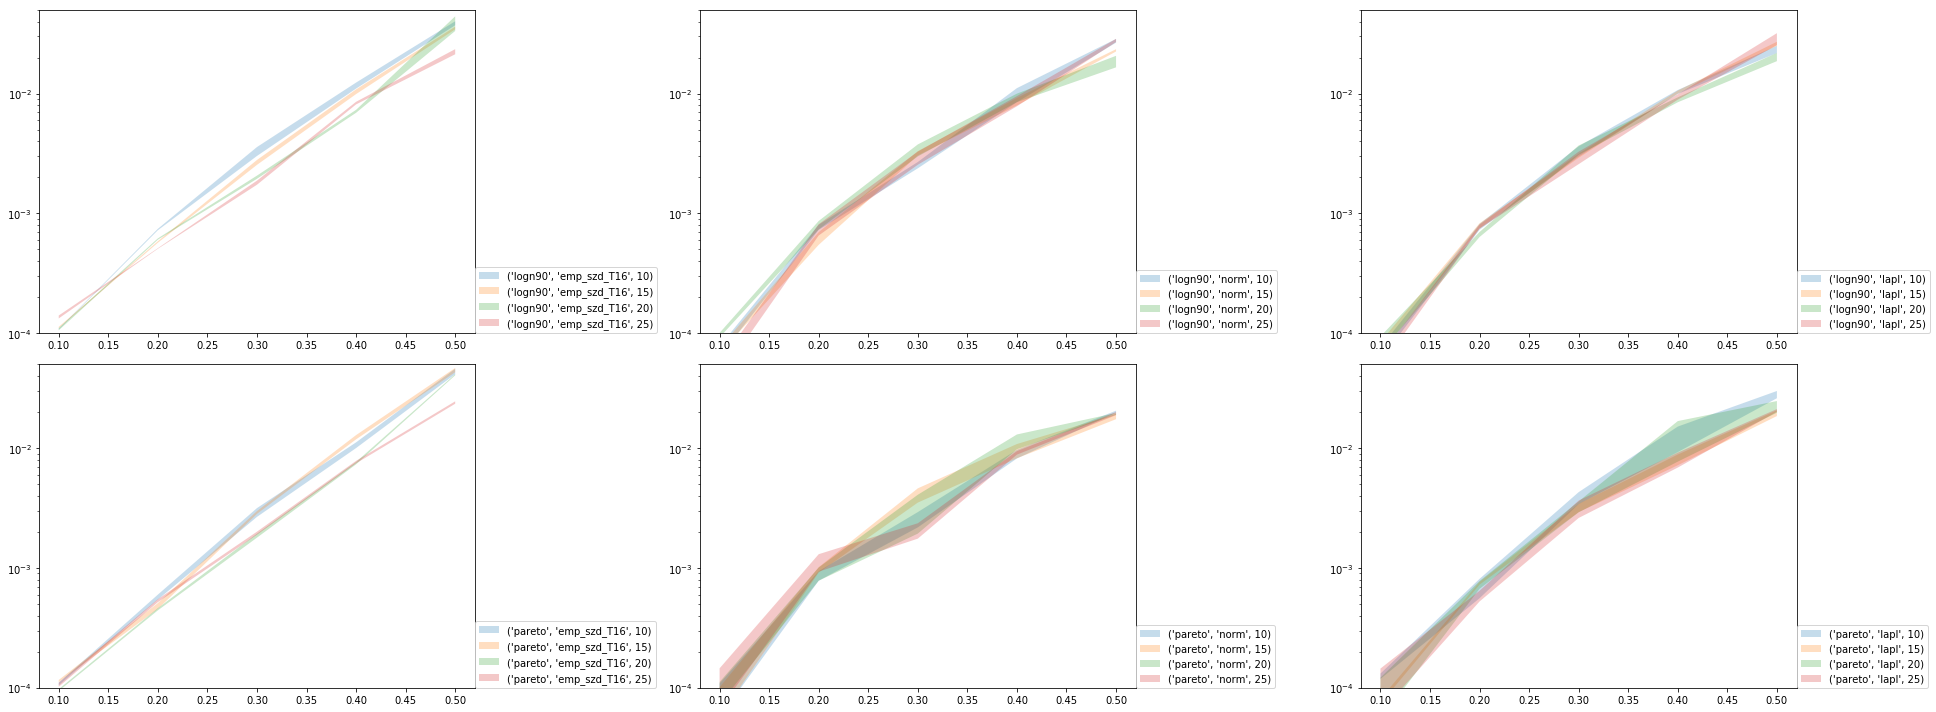

In [135]:
# variance in the y. M = 10

In [74]:

var_i_list = []
var_diff_i_list = []
for m in range(10):
    sim_m = x0_pool_part.groupby('q').apply(lambda x: x.sample())
    # sim_m['test'] = sim_m['var_diff_qi'] + sim_m['dev_median']

    value_sum = sim_m[[str(t) for t in range(T + 1)]].sum()
    # sim_m plays the role of df_i in the loops I was using before

    var_i = np.log10(value_sum).var() # we possibly want the var of logs.
    var_diff_i = np.log10(value_sum).diff().var() 
    var_i_list += [var_i]
    var_diff_i_list += [var_diff_i]
pd.DataFrame([var_i_list, var_diff_i_list], index = ['var_i_list', 'var_diff_i_list'])

,0,1,2,3,4,5,6,7,8,9
var_i_list,0.019283,0.013681,0.014053,0.016992,0.020052,0.016263,0.022845,0.020981,0.019363,0.016765
var_diff_i_list,0.004033,0.002732,0.002885,0.003318,0.004474,0.002696,0.004625,0.004557,0.004129,0.002961


In [ ]:
## Check if I can just use the small fluctuation linear case integral / .mean()

In [458]:
for sizes in ['logn90', 'pareto']:
#     print(sizes)

    for dist in ['emp_szd_T16','norm', 'lapl']:
#         print(dist)
        # Load previously simulated
        df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_40i_.csv')
        
        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index]#.reset_index().set_index(['Q', 'q', 'i'])

In [459]:
df.head()

q  index             0             1             2             3  \
s   Q  i                                                                     
0.1 10 0  0      0  2.434197e+10  2.483409e+10  2.516254e+10  2.557290e+10   
       0  1      1  2.441526e+10  2.491052e+10  2.541083e+10  2.570653e+10   
       0  2      2  2.425871e+10  2.487286e+10  2.520954e+10  2.581738e+10   
       0  3      3  2.419713e+10  2.493837e+10  2.573783e+10  2.603674e+10   
       0  4      4  2.413236e+10  2.456204e+10  2.437958e+10  2.426503e+10   

                     4             5             6             7  ...  \
s   Q  i                                                          ...   
0.1 10 0  2.572390e+10  2.593181e+10  2.618065e+10  2.632305e+10  ...   
       0  2.590453e+10  2.634238e+10  2.634030e+10  2.639251e+10  ...   
       0  2.619441e+10  2.654152e+10  2.630507e+10  2.649638e+10  ...   
       0  2.606144e+10  2.625729e+10  2.696566e+10  2.714343e+10  ...   
       0  2.476604e+10  2.485724e+10  2.569932e+10  2.621187e+10  ...   

                    13            14            15            16    var_qi  \
s   Q  i                                                                     
0.1 10 0  2.541431e+10  2.487087e+10  2.429887e+10  2.366049e+10  0.000238   
       0  2.528902e+10  2.478294e+10  2.439781e+10  2.365400e+10  0.000184   
       0  2.542336e+10  2.494618e+10  2.434310e+10  2.366624e+10  0.000210   
       0  2.448822e+10  2.430340e+10  2.395142e+10  2.362313e+10  0.000356   
       0  2.525374e+10  2.458097e+10  2.449209e+10  2.359956e+10  0.000368   

          var_diff_qi  var_agg_i  var_diff_agg_i  dist   sizes  
s   Q  i                                                        
0.1 10 0     0.000045   0.000022        0.000023  lapl  pareto  
       0     0.000042   0.000022        0.000023  lapl  pareto  
       0     0.000050   0.000022        0.000023  lapl  pareto  
       0     0.000073   0.000022        0.000023  lapl  pareto  
       0     0.000101   0.000022        0.000023  lapl  pareto  

[5 rows x 25 columns]

(1e-05, 4.997775174974212)

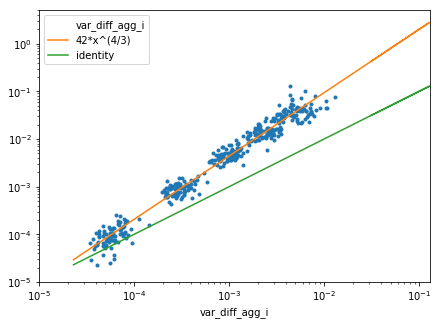

In [536]:
# df['var_diff_qi/Q'] = df['var_diff_qi']/df.index.get_level_values('Q')
df['var_diff_qi/Q'] = df['var_diff_qi']/df.index.get_level_values('Q')
integral_result = df.groupby(level = ['s', 'Q', 'i'])[['var_diff_qi/Q', 'var_diff_agg_i']].mean()


fig, ax = plt.subplots(1, figsize = (7, 5))
integral_result.plot(x = 'var_diff_qi/Q', y = 'var_diff_agg_i', marker = '.', lw = 0, ax = ax)

x = np.log10(integral_result['var_diff_qi/Q'])
line = np.polyfit(x, np.log10(integral_result['var_diff_agg_i']), 1)

integral_result['y'] = integral_result['var_diff_agg_i'].copy()**(line[0])*np.power(10, line[1])
integral_result.plot(x = 'var_diff_agg_i', y = 'y', ax = ax, label = '42*x^(4/3)')

integral_result['y'] = integral_result['var_diff_agg_i'].copy()
integral_result.plot(x = 'var_diff_agg_i', y = 'y', ax = ax, label = 'identity')

# ax.plot(x, line[0]*x + line[1])
plt.xscale('log')
plt.yscale('log')

plt.xlim(1e-5, )
plt.ylim(1e-5, )

In [535]:
np.power(10, line[1])
# line[0]

42.53387057089066

In [129]:
# Here we do an experiment where we set levels of background variance and see the oo of the dependence with many quantiles.
# The idea is to have a correct idea of the dependence around zero.
# I have seen an expression where var = var_q/Q. How does it look in real 

## Import 
# df = pd.read_csv('./../../data/processed/exp_var_lapl_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_sbtn_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()

T = 16
t0D = .4
# the variable to fit

df_xy_list = []
var_diff_i_list = []
sizes = 'logn90'
 
for dist in ['norm', 'lapl']:
    print(dist)
    # Load previously simulated
    filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
    df = pd.read_csv(filename).set_index(['Q', 'q', 'i']).sort_index()
    df['ti'] = df['var_qi']/df['s']**2
    df['tdiffi'] = df['var_diff_qi']/df['s']**2
    
    I = df.index.get_level_values('i').max() + 1; keep = int(.5*I)    
    ### 
    # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
    ###
    df = df.reset_index().set_index(['s','Q', 'q', 'i'])
    df_lin_vals = df[[str(t) for t in range(T + 1)]]
    grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
    acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
    acceptables.index = acceptables.index.droplevel([0, 1])
    df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])

#     hvar = 'ti'
    hvar = 'tdiffi'
    hvar0 = 'tdiff0'
    
    values_check = df.reset_index()[['q', hvar]].sort_values(by = ['q', hvar])
    s_dist_grouped = values_check.groupby('q').agg(['min', 'max'])[hvar]
    # parametric pts between these values
    t0i = s_dist_grouped[['min']].quantile(.7).values
    t0f = s_dist_grouped[['max']].quantile(.3).values
    dist_s_t0_levels = (t0i + np.arange(0, 1, t0D)*(t0f - t0i)).round(4)
    
    for s in [0.2, 0.4]:#df.s.unique():
        df_ = df.loc[df.s == s]
        
        ###
        # DECIDE ON THE X0 LEVELS.
        ###
        # They could be the median or they could also be some fixed levels of x0. 

#         df['dev_median'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))[y]#.plot(marker = '.')
#         df_x0var_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_median').reset_index(drop = True))

        # # Pool of qi's with the required x0
        df_ = df_.drop(['dist', 'sizes'], axis = 1)
        for t0 in dist_s_t0_levels:
            df_['dev_t0'] = df_.groupby(level=[0,1]).apply(lambda x: abs(x - t0))[hvar]#.plot(marker = '.')
            df_t0var_pool = df_.groupby(level=[0,1]).apply(lambda x: x.nsmallest(1, 'dev_t0').reset_index(drop = True))

            for Q_ in df_.index.get_level_values('Q').unique():
                df_Q = df_.loc[Q_]

                # Option 1. Sample median blocks only once. Shuffling of other blocks will not introduce noise.
#                 t0_draw = df_t0var_pool.loc[Q_].groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
                t0_draw = df_t0var_pool.loc[Q_]
                t0_draw = t0_draw.rename(columns = {'ti': 't0q', 'tdiffi': 'tdiff0q'})
                
                df_xy_qparts_list = []
                for q in range(Q_):
                    print(s, t0, Q_, q)
                    df_q = df_Q.loc[q]
                    
                    df_q_part = df_q
                    var_i_list = []
                    var_diff_i_list = []
                    for i, row in df_q_part.iterrows():
                        # Insert the i row in place of the median for q.
                        df_i = t0_draw.copy()
                        row = pd.DataFrame(row).T
                        row.index = pd.MultiIndex.from_product([[q], row.index])
                        df_i = df_i.drop(q).append(row)

                        # Do the total, get it's var. this is 'y'. store
                #         var_i = df_i[range(T)].sum().var()
                        value_sum = df_i[[str(t) for t in range(T + 1)]].sum()
                        var_i = np.log10(value_sum).var() # we possibly want the var of logs.
                        var_diff_i = np.log10(value_sum).diff().var() 
                        var_i_list += [var_i]
                        var_diff_i_list += [var_diff_i]
                    df_xy_qpart = df_q_part[['var_qi', 'var_diff_qi']]
                    df_xy_qpart['t_qi'] = df_xy_qpart['var_qi']/s**2
                    df_xy_qpart['tdiff_qi'] = df_xy_qpart['var_diff_qi']/s**2
                    df_xy_qpart['y'] = np.array(var_i_list)
                    df_xy_qpart['ydiff'] = np.array(var_diff_i_list)
                    df_xy_qpart['q'] = q
                    df_xy_qpart = df_xy_qpart.reset_index() # so that we have the i's as a column

                    df_xy_qparts_list += [df_xy_qpart]

                df_xy_ = pd.concat(df_xy_qparts_list)
                df_xy_['Q'] = Q_
                df_xy_['s'] = s
                df_xy_['dist'] = dist
                df_xy_[hvar0] = t0 # this is the theoretical/aimed one
                # merge the actual t0 of all 
                df_xy_ = df_xy_.merge(t0_draw.reset_index()[['q', hvar0+'q']]) # this is the actual one
                # these are the 'y0' levels
                value_sum_t0 = t0_draw[[str(t) for t in range(T + 1)]].sum()
                df_xy_['var_t0'] = np.log10(value_sum).var() # we possibly want the var of logs.
                df_xy_['var_diff_t0'] = np.log10(value_sum).diff().var() 
                df_xy_list += [df_xy_]

df_xy = pd.concat(df_xy_list)
df_xy['y/s2'] = df_xy['y']/(df_xy.s)**2
df_xy['ydiff/s2'] = df_xy['ydiff']/(df_xy.s)**2
df_xy['var_t0/s2'] = df_xy['var_t0']/(df_xy.s)**2
df_xy['var_diff_t0/s2'] = df_xy['var_diff_t0']/(df_xy.s)**2

# df_xy['t0'] = df_xy.t0.round(4)
df_xy[hvar0] = df_xy[hvar0].round(4)
# df_xy.to_csv('./../../data/processed/20190715_depce_test_'+sizes+'_diff.csv')

norm
0.2 0.0471 10 0


KeyboardInterrupt: 

## Loop adapted for median

In [130]:
# Here we do an experiment where we set levels of background variance and see the oo of the dependence with many quantiles.
# The idea is to have a correct idea of the dependence around zero.
# I have seen an expression where var = var_q/Q. How does it look in real 

## Import 
# df = pd.read_csv('./../../data/processed/exp_var_lapl_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_sbtn_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()

T = 16
t0D = .4
# the variable to fit

df_xy_list = []
var_diff_i_list = []
sizes = 'logn90'
 
for dist in ['norm', 'lapl']:
    print(dist)
    # Load previously simulated
    filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
    df = pd.read_csv(filename).set_index(['Q', 'q', 'i']).sort_index()
    df['ti'] = df['var_qi']/df['s']**2
    df['tdiffi'] = df['var_diff_qi']/df['s']**2
    
    I = df.index.get_level_values('i').max() + 1; keep = int(.5*I)    
    ### 
    # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
    ###
    df = df.reset_index().set_index(['s','Q', 'q', 'i'])
    df_lin_vals = df[[str(t) for t in range(T + 1)]]
    grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
    acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
    acceptables.index = acceptables.index.droplevel([0, 1])
    df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])

#     hvar = 'ti'
    hvar = 'tdiffi'
    hvar0 = 'tdiff0'
    
#     values_check = df.reset_index()[['q', hvar]].sort_values(by = ['q', hvar])
#     s_dist_grouped = values_check.groupby('q').agg(['min', 'max'])[hvar]
#     # parametric pts between these values
#     t0i = s_dist_grouped[['min']].quantile(.7).values
#     t0f = s_dist_grouped[['max']].quantile(.3).values
#     dist_s_t0_levels = (t0i + np.arange(0, 1, t0D)*(t0f - t0i)).round(4)
    dist_s_t0_levels = np.array(['median'])

    for s in [0.2, 0.4]:#df.s.unique():
        df_ = df.loc[df.s == s]
        
        ###
        # DECIDE ON THE X0 LEVELS.
        ###
        # They could be the median or they could also be some fixed levels of x0. 

#         df['dev_median'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))[y]#.plot(marker = '.')
#         df_x0var_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_median').reset_index(drop = True))

        # # Pool of qi's with the required x0
        df_ = df_.drop(['dist', 'sizes'], axis = 1)
        for t0 in dist_s_t0_levels:
#             df_['dev_t0'] = df_.groupby(level=[0,1]).apply(lambda x: abs(x - t0))[hvar]#.plot(marker = '.') ### ATENCION
            df_['dev_t0'] = df_.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))[hvar]#.plot(marker = '.')
            df_t0var_pool = df_.groupby(level=[0,1]).apply(lambda x: x.nsmallest(1, 'dev_t0').reset_index(drop = True))

#             for Q_ in df_.index.get_level_values('Q').unique():
            for Q_ in [10, 20]:
                df_Q = df_.loc[Q_]

                # Option 1. Sample median blocks only once. Shuffling of other blocks will not introduce noise.
#                 t0_draw = df_t0var_pool.loc[Q_].groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
                t0_draw = df_t0var_pool.loc[Q_]
                t0_draw = t0_draw.rename(columns = {'ti': 't0q', 'tdiffi': 'tdiff0q'})
                
                df_xy_qparts_list = []
                for q in range(Q_):
                    print(s, t0, Q_, q)
                    df_q = df_Q.loc[q]
                    
                    df_q_part = df_q
                    var_i_list = []
                    var_diff_i_list = []
                    for i, row in df_q_part.iterrows():
                        # Insert the i row in place of the median for q.
                        df_i = t0_draw.copy()
                        row = pd.DataFrame(row).T
                        row.index = pd.MultiIndex.from_product([[q], row.index])
                        df_i = df_i.drop(q).append(row)

                        # Do the total, get it's var. this is 'y'. store
                #         var_i = df_i[range(T)].sum().var()
                        value_sum = df_i[[str(t) for t in range(T + 1)]].sum()
                        var_i = np.log10(value_sum).var() # we possibly want the var of logs.
                        var_diff_i = np.log10(value_sum).diff().var() 
                        var_i_list += [var_i]
                        var_diff_i_list += [var_diff_i]
                    df_xy_qpart = df_q_part[['var_qi', 'var_diff_qi']]
                    df_xy_qpart['t_qi'] = df_xy_qpart['var_qi']/s**2
                    df_xy_qpart['tdiff_qi'] = df_xy_qpart['var_diff_qi']/s**2
                    df_xy_qpart['y'] = np.array(var_i_list)
                    df_xy_qpart['ydiff'] = np.array(var_diff_i_list)
                    df_xy_qpart['q'] = q
                    df_xy_qpart = df_xy_qpart.reset_index() # so that we have the i's as a column

                    df_xy_qparts_list += [df_xy_qpart]

                df_xy_ = pd.concat(df_xy_qparts_list)
                df_xy_['Q'] = Q_
                df_xy_['s'] = s
                df_xy_['dist'] = dist
                df_xy_[hvar0] = t0 # this is the theoretical/aimed one
                # merge the actual t0 of all 
                df_xy_ = df_xy_.merge(t0_draw.reset_index()[['q', hvar0+'q']]) # this is the actual one
                # these are the 'y0' levels
                value_sum_t0 = t0_draw[[str(t) for t in range(T + 1)]].sum()
                df_xy_['var_t0'] = np.log10(value_sum).var() # we possibly want the var of logs.
                df_xy_['var_diff_t0'] = np.log10(value_sum).diff().var() 
                df_xy_list += [df_xy_]

df_xy = pd.concat(df_xy_list)
df_xy['y/s2'] = df_xy['y']/(df_xy.s)**2
df_xy['ydiff/s2'] = df_xy['ydiff']/(df_xy.s)**2
df_xy['var_t0/s2'] = df_xy['var_t0']/(df_xy.s)**2
df_xy['var_diff_t0/s2'] = df_xy['var_diff_t0']/(df_xy.s)**2

# df_xy['t0'] = df_xy.t0.round(4)
# df_xy[hvar0] = df_xy[hvar0].round(4)
# df_xy.to_csv('./../../data/processed/20190715_depce_test_'+sizes+'_diff_mediant0.csv')
df_xy.to_csv('./../../data/processed/20190718_depce_test_'+sizes+'_diff_mediant0.csv')

norm
0.2 median 10 0
0.2 median 10 1
0.2 median 10 2
0.2 median 10 3
0.2 median 10 4
0.2 median 10 5
0.2 median 10 6
0.2 median 10 7
0.2 median 10 8
0.2 median 10 9
0.2 median 20 0
0.2 median 20 1
0.2 median 20 2
0.2 median 20 3
0.2 median 20 4
0.2 median 20 5
0.2 median 20 6
0.2 median 20 7
0.2 median 20 8
0.2 median 20 9
0.2 median 20 10
0.2 median 20 11
0.2 median 20 12
0.2 median 20 13
0.2 median 20 14
0.2 median 20 15
0.2 median 20 16
0.2 median 20 17
0.2 median 20 18
0.2 median 20 19
0.4 median 10 0
0.4 median 10 1
0.4 median 10 2
0.4 median 10 3
0.4 median 10 4
0.4 median 10 5
0.4 median 10 6
0.4 median 10 7
0.4 median 10 8
0.4 median 10 9
0.4 median 20 0
0.4 median 20 1
0.4 median 20 2
0.4 median 20 3
0.4 median 20 4
0.4 median 20 5
0.4 median 20 6
0.4 median 20 7
0.4 median 20 8
0.4 median 20 9
0.4 median 20 10
0.4 median 20 11
0.4 median 20 12
0.4 median 20 13
0.4 median 20 14
0.4 median 20 15
0.4 median 20 16
0.4 median 20 17
0.4 median 20 18
0.4 median 20 19
lapl
0.2 median

TypeError: can't multiply sequence by non-int of type 'float'

In [5]:
df_.index.get_level_values('Q').unique()

Int64Index([10, 15, 20, 25], dtype='int64', name='Q')

In [133]:
df_xy.to_csv('./../../data/processed/20190718_depce_test_'+sizes+'_diff_mediant0.csv')

### Fit lines/parabolas for slope at x0.

In [145]:
# # ## Load if needed 
# df_xy1 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full.csv')
# df_xy2 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full2.csv')
# df_xy3 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full3.csv')
# df_xy = pd.concat([df_xy1, df_xy2, df_xy3], axis = 0)

# # Falta Q = 20, q in (0, 5)
# # df_xy.groupby(['Q', 'q']).count().loc[20]

# df_xy = pd.read_csv('./../../data/processed/20190715_depce_test.csv')

In [6]:
# Scale by s2. Careful not to run twice.

# df_xy['var_qi'] = df_xy['var_qi']/(df_xy.s)**2
# df_xy['y/s2'] = df_xy['y']/(df_xy.s)**2
# df_xy['ydiff/s2'] = df_xy['ydiff']/(df_xy.s)**2
# df_xy['t0'] = df_xy['x0']/(df_xy.s)**2

# Actually (var_qi - x0) should be now (t_qi - t0) and 'y' should be (sigma/s)

In [150]:
# for dist in ['norm', 'lapl']:
#     print(dist)
#     # Load previously simulated
#     filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
#     df = pd.read_csv(filename).set_index(['Q', 'q', 'i']).sort_index()
    
# print(df_xy.groupby('dist').s.unique())

dist
lapl    [0.1, 0.2, 0.3, 0.4, 0.5]
norm                   [0.1, 0.3]
Name: s, dtype: object


In [122]:
# df_xy_ = 
# df_xy_.merge(t0_draw.reset_index()[['q', hvar]].rename(columns = {hvar: hvar+'q'}))


0.3833043834659016

norm
10
20
lapl
10
20


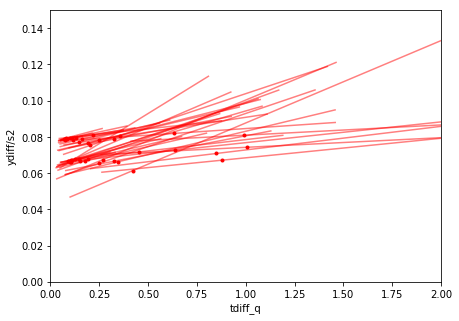

In [181]:
xvar = 'tdiff_qi'
yvar = 'ydiff/s2'
t0var = 'tdiff0'


fig, ax = plt.subplots(1, figsize = (7, 5))

fits1 = []
fits2 = []
for dist in df_xy.dist.unique():
    print(dist)
    df_xy_d = df_xy.loc[df_xy.dist == dist]
    for Q in df_xy.Q.unique():
        print(Q)
        df_xy_dQ = df_xy_d.loc[df_xy_d.Q == Q]
        for s in df_xy.s.unique():
            df_xy_dQs = df_xy_dQ.loc[df_xy_dQ.s == s]
            for q in range(Q):
                
                df_xy_dQqs = df_xy_dQs.loc[df_xy_dQs.q == q]
                for t0 in df_xy_dQqs[hvar0].unique():
                    df_xy_dQqs0 = df_xy_dQqs.loc[df_xy_dQqs[hvar0] == t0]
                    t0q = df_xy_dQqs0.tdiff0q.unique()[0] # There should be only one value for all the i's with this q

                    x = df_xy_dQqs0[xvar]
                    y = df_xy_dQqs0[yvar]
                    corrcoef = np.corrcoef(x, y)[0, 1]

                    line = np.polyfit(x, y, 1)
                    curv = np.polyfit(x, y, 2)

                    fits1 += [np.hstack((line, [q, Q, s, dist, t0, t0q, corrcoef, x.std(), y.std()]))]
                    fits2 += [np.hstack((curv, [q, Q, s, dist, t0, t0q, corrcoef, x.std(), y.std()]))]
                    
                    df_xy_q = df_xy.loc[df_xy.q == q]

                if (s, Q) == (.4, 20):
#                 if s == .4:
                    df_xy_dQqs0 = df_xy_dQqs.loc[df_xy_dQqs[hvar0] == df_xy_dQqs[hvar0].unique()[0]]
    
#                     ax.plot(df_xy_dQqs0[xvar], df_xy_dQqs0[yvar], '.', alpha = .5)

                    xfit = np.arange(x.min(), x.max(), .01)
                    ax.plot(xfit, xfit*line[0] + line[1], c = 'r', alpha = .5)
                    ax.scatter(x.median(), x.median()*line[0] + line[1], c = 'r', marker = '.')
                    
#                     bin_mean = df_xy_dQqs0.groupby(pd.qcut(df_xy_dQqs0[xvar], 10)).mean()
#                     bin_mean.plot(xvar, yvar, marker = 'o', ax = ax)

                    ax.set_xlim(0, 2)
                    ax.set_ylim(0, .15)
                    ax.set_xlabel('tdiff_q') 
                    ax.set_ylabel('ydiff/s2')
plt.show()

In [182]:
fits1 = pd.DataFrame(np.array(fits1), columns = ['a', 'b', 'q', 'Q', 's', 'dist', hvar0, hvar0+'q', 'corr', 'sx', 'sy'])
fits2 = pd.DataFrame(np.array(fits2), columns = ['a', 'b', 'c', 'q', 'Q', 's', 'dist', hvar0, hvar0+'q', 'corr', 'sx', 'sy'])

for df_ in [fits1, fits2]:
    for col in df_.columns:
        df_[col] = pd.to_numeric(df_[col], errors='ignore')
    
# x = 0.03
# df_.a*x**2 + df_.b**x + df_.c

# fits1['s0'] = 2 * fits1.a * fits1.x0 + fits1.b
fits1['s0/s2'] = fits1.a * fits1[hvar0+'q'] + fits1.b

fits1.to_csv('./../../data/processed/20190718_depce_test_fits1_'+sizes+'_diff_median.csv', index = False)
fits2.to_csv('./../../data/processed/20190718_depce_test_fits2_'+sizes+'_diff_median.csv', index = False)

In [183]:
fits1.nunique()

a          120
b          120
q           20
Q            2
s            2
dist         2
tdiff0       1
tdiff0q    120
corr       120
sx         120
sy         120
s0/s2      120
dtype: int64

In [132]:
# fits1.plot(x = 'tdiff0',y = 'tdiff0q', marker = '.', lw = 0)
# fits1.hist('tdiff0q',bins = 50)

## Decomposition into slope + sx

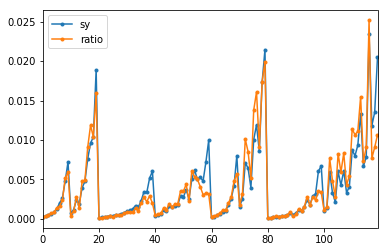

In [196]:
# fits1['ratio'] = fits1['corr']*fits1['sy']/fits1['sx']
fits1['ratio'] = fits1['a']*fits1['sx']/(fits1['corr'].mean())

fits1[['sy', 'ratio']].plot(marker = '.')
# fits1['corr'].plot(marker = '.'); plt.ylim(-1, 1)

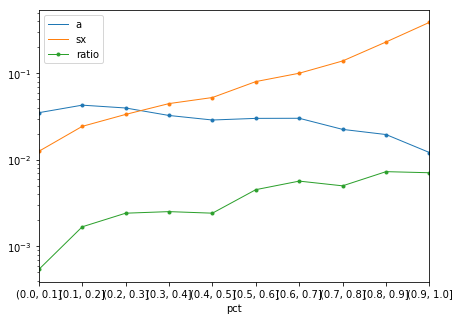

In [209]:
fits1['pct'] = (fits1['q'] + .5)/fits1['Q']
fits1['pct'] = pd.cut(fits1['pct'], np.arange(0, 1.1, 0.1))
fits1 = fits1.groupby('pct').mean().reset_index()

fig, ax = plt.subplots(1, figsize = (7, 5))
fits1.plot('pct', 'a', marker = '.', lw = 1, ax = ax)
fits1.plot('pct', 'sx', marker = '.', lw = 1, ax = ax)
fits1.plot('pct', 'ratio', marker = '.', lw = 1, ax = ax)
ax.set_yscale('log')

## Debug of the Series approx

In [42]:
pd.options.display.max_columns = 50

In [136]:
fits1['tdiff0q'] = fits1['tdiff0q'].round(10);
df_xy['tdiff0q'] = df_xy['tdiff0q'].round(10);
# saved numerical mismatch

merged = fits1.merge(df_xy, on = ['Q', 'q', 's', 'dist', 'tdiff0', 'tdiff0q'])
# merged = merged.loc[(merged.s == .2) & (merged.Q == 10)]
# .nunique()
merged.nunique()

a                   120
b                   120
q                    20
Q                     2
s                     2
dist                  2
tdiff0                1
tdiff0q             120
s0/s2               120
i                   399
var_qi            24000
var_diff_qi       24000
t_qi              24000
tdiff_qi          24000
y                 23894
ydiff             23893
var_t0                8
var_diff_t0           8
y/s2              23894
ydiff/s2          23893
var_t0/s2             8
var_diff_t0/s2        8
dtype: int64

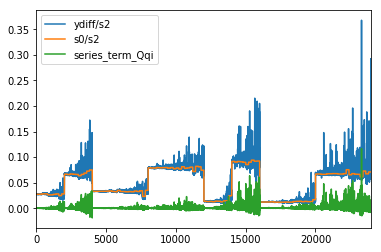

In [137]:
merged['series_term_Qqi'] = merged['a']*merged['tdiff_qi'] + merged['b'] - merged['s0/s2']

merged[['ydiff/s2', 's0/s2', 'series_term_Qqi']].plot(alpha = 1)

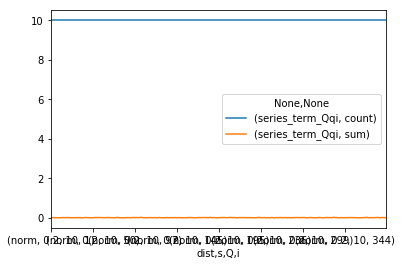

In [95]:
merged.groupby(['dist', 's', 'Q', 'i']).aggregate({'series_term_Qqi': ['count', 'sum']}).plot()

In [63]:
fits1
df_xy.loc[(df_xy.s > .19) & (df_xy.Q == 10)].nunique()

i                  200
var_qi            2000
var_diff_qi       2000
t_qi              2000
tdiff_qi          2000
y                 1991
ydiff             1991
q                   10
Q                    1
s                    1
dist                 1
tdiff0               1
tdiff0q             10
var_t0               1
var_diff_t0          1
y/s2              1991
ydiff/s2          1991
var_t0/s2            1
var_diff_t0/s2       1
dtype: int64

In [102]:
fits1.head()

,a,b,q,Q,s,dist,tdiff0,tdiff0q,s0/s2
0,0.089526,0.013525,0,10,0.1,norm,median,0.004534,0.013931
1,0.058408,0.013806,1,10,0.1,norm,median,0.005291,0.014115
2,0.053425,0.013016,2,10,0.1,norm,median,0.006700,0.013374
3,0.040486,0.013041,3,10,0.1,norm,median,0.009285,0.013417
4,0.032911,0.012423,4,10,0.1,norm,median,0.013871,0.012879


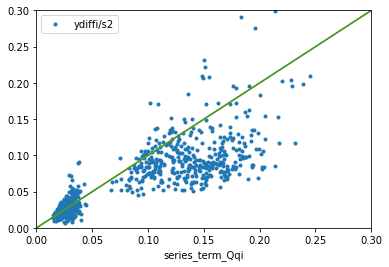

In [148]:
# Actual cases where all variables depart in different directions

df['tdiffi'] = df['var_diff_qi']/df['s']**2
df['ydiffi/s2'] = df['var_diff_agg_i']/df['s']**2

merged = df[['s', 'var_diff_qi', 'ydiffi/s2', 'dist', 'sizes','tdiffi']].reset_index().merge(fits1[['a','b','q','Q','s','dist']])
merged['series_term_Qqi'] = merged['a']*merged['tdiffi']

result_direct = merged.groupby(['dist', 's', 'Q', 'i']).aggregate({'series_term_Qqi': 'sum', 'ydiffi/s2': 'first'})

result_direct.plot(x = 'series_term_Qqi', y = 'ydiffi/s2', marker = '.', lw = 0)
plt.plot([[0, 0], [1, 1]])
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.show()


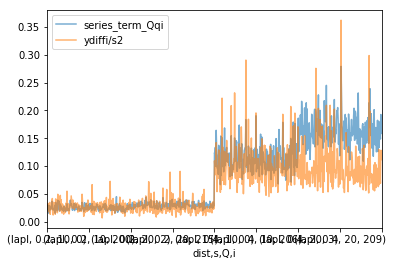

In [144]:
result_direct.plot(alpha = .6)

In [147]:
result_direct.groupby(level = [0,1,2]).count()

series_term_Qqi  ydiffi/s2
dist s   Q                             
lapl 0.2 10              200        200
         20              200        200
     0.4 10              200        200
         20              200        200

# Analysis

KeyError: 's0'

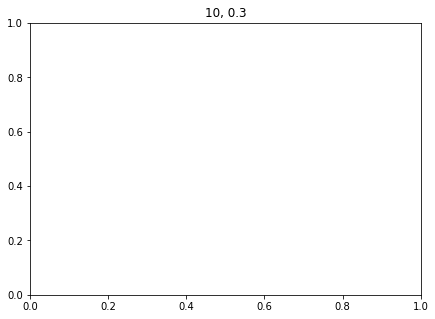

In [832]:
# # Dependence with Q and s


for Q_ in df_.Q.unique():
    fig, ax = plt.subplots(1, figsize = (7, 5))
    ax.set_title(str(Q_)+', '+str(s_))
    for s_ in df_.s.unique():
        df_.loc[(df_.Q == Q_) & (df_.s == s_)].plot('x0', 's0', marker = '.', lw = 0, ax = ax)
#         ax.set_xlim(0, 0.025)
#         ax.set_ylim(0, 0.04)
    plt.show()
    
# Attention. We want x0 values to be comfortably reachable. Otherwise I will just be having them clipped for some of the Q, s, q combinations.

values_check = df_xy.reset_index(drop = True).drop(['y', 'x0'], axis = 1).drop_duplicates().sort_values(by = ['q', 'var_qi'])
# grouped = values_check.loc[(values_check.dist == 'norm')].groupby(['Q', 's', 'q'])
grouped = values_check.groupby(['dist','s', 'q'])

fig, ax = plt.subplots(1, figsize = (17, 5))
grouped.agg(['min', 'max'])['var_qi'].plot(ax = ax)
# ax.axhline(0.01)
# ax.axhline(0.02)
# ax.set_ylim(0, 0.03)
ax.set_yscale('log')

s_dist_grouped = grouped.agg(['min', 'max'])['var_qi'].groupby(level = [0, 1])
x0_s_dist = pd.concat([s_dist_grouped['min'].quantile(.7) + \
           l*(s_dist_grouped['max'].quantile(.3) - s_dist_grouped['min'].quantile(.7)) for l in np.arange(0, 1, .1)], axis = 1).round(4)

df_ = grouped.agg(['min', 'max'])['var_qi'].reset_index().merge(x0_s_dist.reset_index()).set_index(['dist', 's', 'q'])
df_[range(10)].plot(color = '.4', linestyle = '--', ax = ax)
plt.show()

[0.418 0.004]
[0.471 0.003]
[0.436 0.002]


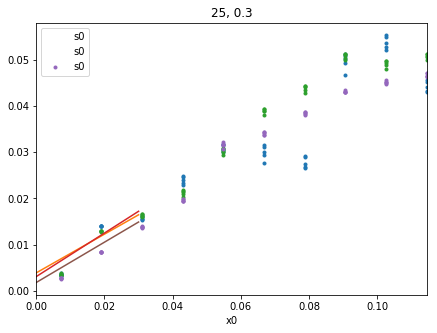

In [801]:
df_ = fits1.set_index(['dist']).loc['norm']
## Dependence with Q

fig, ax = plt.subplots(1, figsize = (7, 5))
aQ = []
for Q_ in df_.Q.unique():
    s_ = .3 
    ax.set_title(str(Q_)+', '+str(s_))
    data = df_.loc[(df_.Q == Q_) & (df_.s == s_)]
    data.plot('x0', 's0', marker = '.', lw = 0, ax = ax)
    
    line = np.polyfit(data.x0, data.s0, 1)
    ax.plot(np.arange(0, 0.035, 0.01), np.arange(0, 0.035, 0.01)*line[0] + line[1])
    print(line.round(3))
    # This is useful for a(Q). For now not a clearly explainable dependence
    aQ += [line[0]]
aQ = np.array(aQ) 
# ax.set_xlim(0, 0.025)
# ax.set_ylim(0, 0.04)
plt.show()

#### Partial derivatives at x0

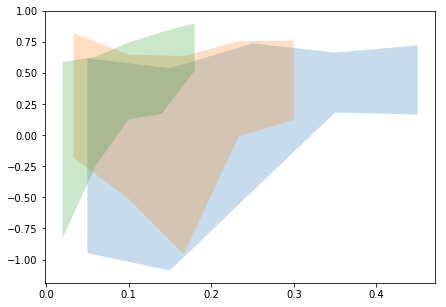

In [802]:
fits2['part_dev_x0'] = 2 * fits2.a * fits2.x0 + fits2.b
df_ = fits2.set_index(['dist']).loc['norm']

part_devs_q = df_.loc[df_.s == .3].groupby(['Q', 'q'])['part_dev_x0'].describe()[['mean', '25%','50%','75%']]
part_devs_q = part_devs_q.reset_index()
part_devs_q['pct'] = (part_devs_q['q'] + .5)/part_devs_q['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in part_devs_q.Q.unique():
    data = part_devs_q.loc[part_devs_q.Q == Q_]
    ax.fill_between(data.pct, Q_*data['25%'], Q_*data['75%'], alpha = .25)
plt.show()
# High q are the little populated, volatile ones.

### The $(\sigma^2_q - \sigma^2_0)$ term
Computed as difference between median and x0. It is just to have a qualitative idea, cause actually $\sigma^2_q$ will be given in each custom case

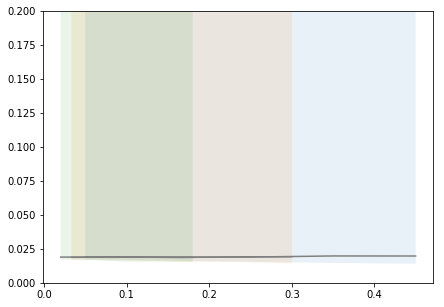

In [803]:
# describe var_qi by dist, Q, q, s (s = .3 for now)
describe = df_xy.loc[df_xy.s == .3].drop(['y','x0'], axis = 1).drop_duplicates().groupby(['dist','Q','q','s'])['var_qi'].describe()
describe = describe.loc['lapl']

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in describe.Q.unique():
    data = describe.loc[describe.Q == Q_]
    ax.fill_between(data.pct, data['25%'], Q_*data['75%'], alpha = .1)
    ax.plot(data.pct, data['50%'], color = '.5')
# plt.yscale('log')
plt.ylim(0, 0.2)
plt.show()


## A term: $\frac{\partial \sigma^2}{\partial \sigma^2_q} (\sigma^2_q - \sigma^2_0) $

We use as x_0 = 0.02 as it is a quite good approx for all the pcts in the lower part of value.

In [804]:
x0_ = 0.019

In [805]:
# describe var_qi by dist, Q, q, s (s = .3 for now)
df_ = df_xy.loc[df_xy.s == .3].drop(['x0'], axis = 1).drop_duplicates()
df_ = df_xy.loc[(df_xy.s == .3) & (df_xy.x0 == x0_)]#.drop(['x0'], axis = 1).drop_duplicates()
describe_var_q = df_.groupby(['dist','Q','q','s'])[['var_qi', 'y']].describe()

df_ = fits2.loc[fits2.s == .3]
describe_part_dev_x0 = df_.groupby(['dist','Q', 'q', 's'])[['part_dev_x0']].describe()

describe = pd.concat([describe_var_q, describe_part_dev_x0], axis = 1)
describe = describe.iloc[:, describe.columns.get_level_values(1).isin(['25%','50%','75%'])]

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

IndexError: list index out of range

AttributeError: 'DataFrame' object has no attribute 'dist'

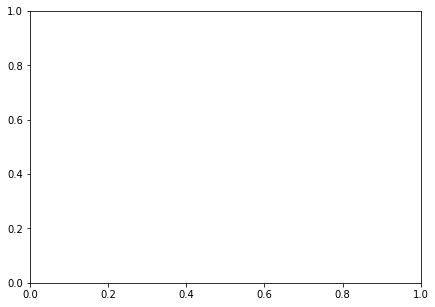

In [806]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - 0.019)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
# plt.ylim(0, 0.02)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are medians

AttributeError: 'DataFrame' object has no attribute 'dist'

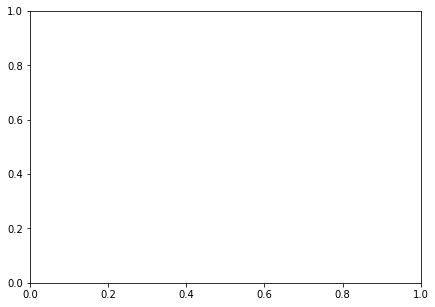

In [787]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - 0.019)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
# plt.ylim(0, 0.02)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are the xqi

In [651]:

for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    
    slice_ = df_xy.loc[(df_xy.s == .3) & (df_xy.dist == 'norm') & (df_xy.Q == Q_) & (df_xy.x0 == x0_)]
    slice_ = slice_.reset_index()
    part_dev_x0 = df_.set_index(['dist', 'Q' , 's', 'q','pct'])['part_dev_x0']['50%'].reset_index().rename(columns = {'50%': 'part_dev_x0'})
# debug. See var_y values for all the i experiments.
# slice_.groupby('i')['y'].describe()[['25%','50%','75%']].plot()
    slice_ = slice_.merge(part_dev_x0)
    slice_['xqi - x0'] = slice_['var_qi'] - slice_['x0']
    slice_['y0'] = y0
    slice_['(x-x0)dy/dx'] = slice_['part_dev_x0']*slice_['xqi - x0']
    slice_ = slice_.sort_values(by = ['i', 'q'])


(0, 0.03)

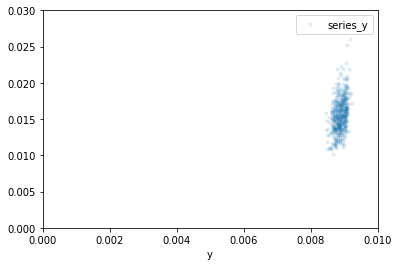

In [675]:
grouped = slice_.groupby('i')
series_approx = grouped['(x-x0)dy/dx'].sum() + grouped['y0'].first()
eval_series = grouped[['y']].quantile(.5)
eval_series['series_y'] = series_approx

eval_series.plot('y', 'series_y', marker = '.', lw = 0, alpha = .1)
plt.xlim(0, 0.01)
plt.ylim(0, 0.03)

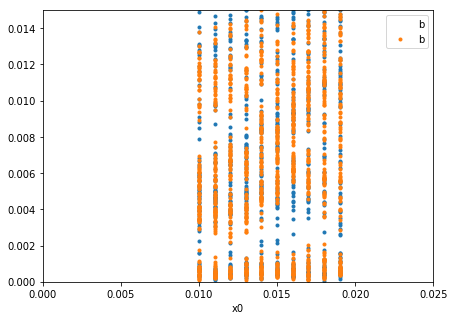

In [354]:
# oo are similar/equal for parabola or linear fits, as they should
# fits1['b2'] = fits2['c']
# fits1.plot('b2', 'b', marker = '.', lw = 0)

df_ = fits1.set_index('Q')[['q', 'x0', 'b']]

# df_['x0_'] = df_['x0'] + np.random.uniform(-0.0003, 0.0003, len(df_))

fig, ax = plt.subplots(1, figsize = (7, 5))
df_.loc[10].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
df_.loc[15].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
ax.set_xlim(0, 0.025)
ax.set_ylim(0, 0.015)
plt.show()

In [331]:
for Q in [10, 15]:
    x = df_.loc[Q]['x0']
    y = df_.loc[Q]['b']
    z = np.polyfit(x, y, 1)
    print(z)

[ 6.11258560e-01 -2.07949449e-04]
[ 5.66583178e-01 -3.52119285e-04]


In [ ]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

In [244]:
qvars_fits(1)

array([[0.05847141, 0.00347405],
       [0.05443393, 0.00193246],
       [0.0560431 , 0.00236648],
       [0.04881516, 0.00201882],
       [0.05625421, 0.00229512],
       [0.06245085, 0.00383869],
       [0.04270722, 0.00239089],
       [0.03508963, 0.00175195],
       [0.03251947, 0.00206818],
       [0.03632867, 0.00237791]])

In [205]:
# low var values
df_mp_Q['var_qi'].groupby('q').max().sum()/(Q_**2)

0.0006697514151924629

(0, 0.02)

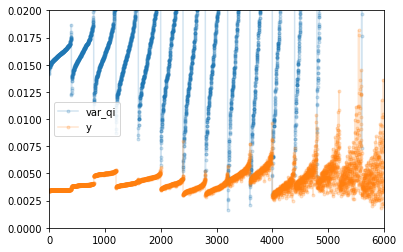

In [221]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
# plt.yscale('log')
plt.ylim(0, 0.02)

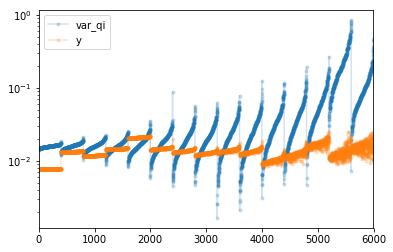

In [167]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

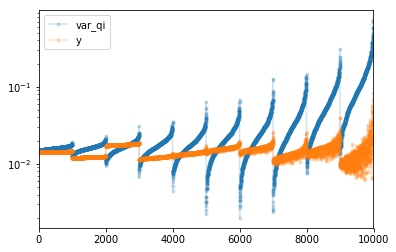

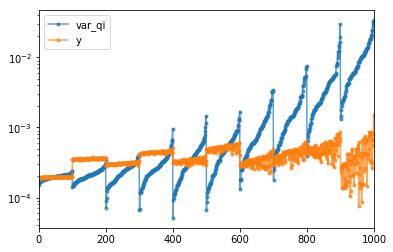

In [232]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

In [ ]:
# For all the variables, get the x y's.
# fit poly, get coefficients, store. 
# option to plot.

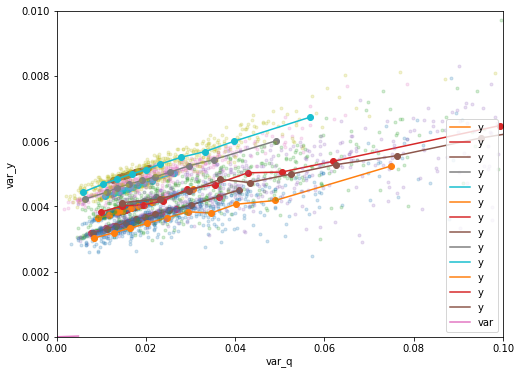

In [217]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

fig, ax = plt.subplots(1, figsize = (8, 6))

for q in range(Q_)[:-2]:
    df_xy_q = df_xy.loc[df_xy.q == q]
    ax.plot(df_xy_q.var_qi, df_xy_q.y, '.', alpha = .2)
    bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
    bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
    ax.set_xlabel('var_q') 
    ax.set_ylabel('var_y')
    
slice_ = result.loc[result.Q == Q_]
slice_['var'] = slice_['var']#*Q_**2
slice_.plot('var_q', 'var', ax = ax)

ax.set_xlim(0, .1)
ax.set_ylim(0, 0.01)
plt.show()
    # Laplace

## Partial devs

In [188]:
def dx2(x, a, b, c):
    return 2 * a * x + b

def dx(x, a, b):
    return a

In [189]:
partial_devs_1 = np.array([dx(np.median(x), *pars) for pars in qvars_fits(1)])
partial_devs_2 = np.array([dx2(np.median(x), *pars) for pars in qvars_fits(2)])

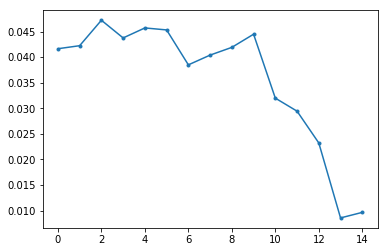

In [190]:
plt.plot(range(Q_), partial_devs_1, marker = '.')
# plt.plot(range(Q_), partial_devs_2, marker = '.')
# plt.plot(range(Q_), fits[:, 0], marker = '.')
# plt.plot(range(Q_), fits[:, 1], marker = '.')
# plt.ylim(0, .07)

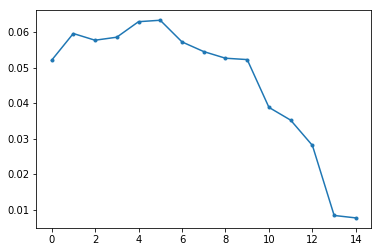

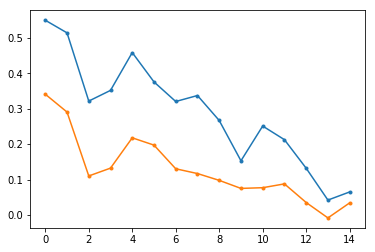

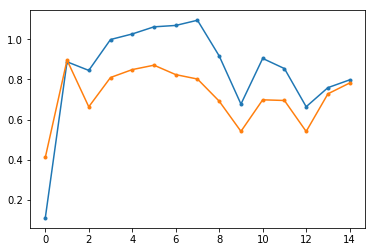

In [245]:
# Gaussian

[0.0863967  0.01296385]
[0.08842814 0.01074267]
[0.09689284 0.01611861]
[0.08432123 0.01063715]
[0.08689185 0.01206402]
[0.09146881 0.01389333]
[0.08071326 0.01385786]
[0.07617694 0.01076438]
[0.04747966 0.01308357]
[0.05237573 0.00767953]


[0.98859968 6.31536187]
[1.0726746  5.50727238]
[1.16982095 8.42172979]
[1.14772977 7.27886601]
[0.99899666 8.59448406]
[ 1.11401587 15.97862462]
[1.3146688  9.78260646]
[1.07650366 8.68275585]
[ 1.18007377 12.5288997 ]
[ 1.09623537 11.0625377 ]


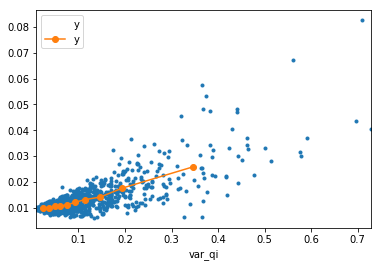

In [252]:
fig, ax = plt.subplots(1)

df_xy_q.plot('var_qi', 'y', marker = '.', lw = 0, ax = ax)
bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

## Test at sigma = 0
What if the sigma_0 point is set at zero? what are the dependencies? 

What happens with Q and the total? The curvature of the log should have an effect

In [207]:
tot_size = 1e11
M = 50000

result_list = []
for Q in [2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    v = []
    for var in np.arange(0, 0.005, 0.0001):
        q_size = np.log10(tot_size/Q)
#         sim_q_size_lin = np.power(10, q_size + np.random.laplace(0, np.sqrt(var), M)/np.sqrt(2))
        sim_q_size_lin = np.power(10, q_size + np.random.normal(0, np.sqrt(var), M))
        sim_log_totals = np.log10(sim_q_size_lin + (1 - 1/Q)*tot_size)
        v += [[var, sim_log_totals.var()]]

    result = pd.DataFrame(np.array(v), columns = ['var_q', 'var'])
    result['Q'] = Q
    result_list += [result]
    
result = pd.concat(result_list)

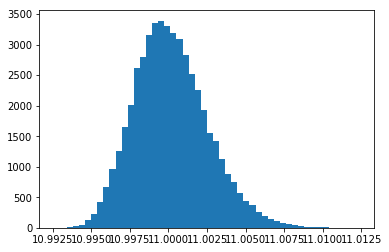

In [208]:
plt.hist(sim_log_totals, 50)
plt.show()

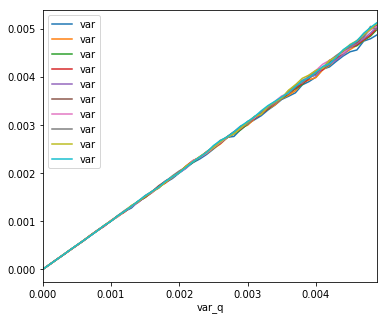

In [209]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for Q in result.Q.unique()[:10]:
    slice_ = result.loc[result.Q == Q]
    slice_['var'] = Q**2*slice_['var']
    slice_.plot('var_q', 'var', ax = ax)

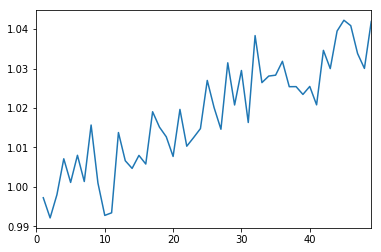

In [162]:
(slice_['var']/slice_['var_q']).plot()